# Extract boxes with PyTorch

In [1]:
# !pip install -U toposort
# !pip uninstall -y torch
# !pip install -U http://download.pytorch.org/whl/cu80/torch-0.2.0.post3-cp36-cp36m-manylinux1_x86_64.whl

In [2]:
%load_ext autoreload
%autoreload 2

import multiprocessing

if __name__ == '__main__':
    multiprocessing.set_start_method('spawn', force=True)

import os, glob, json, tqdm, pandas, pickle, rtree, gc, toposort, joblib, tabulate, lxml.etree
import matplotlib.pyplot as plt
%pylab inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from imgaug import augmenters as iaa
from imgaug import imgaug as ia
from PIL import Image

from IPython.display import display

from intracell_utils.data_source import *

from prepare_images_utils import *
from latex_dataset import *

Populating the interactive namespace from numpy and matplotlib


## Prepare data source

### Table detection

In [3]:
DET_SRC_DIR = './data/arxiv/inout_pairs/'
all_det_image_ids = [fname[:-9]
                     for fname in glob.glob(os.path.join(DET_SRC_DIR, '*_out.json'))]
random.shuffle(all_det_image_ids)

In [4]:
# all_det_image_ids, strange_det_images = leave_only_valid_samples(all_det_image_ids, prepare_det_batch, fake_imgaug_pipeline)
all_det_image_ids, strange_det_images = all_det_image_ids, []
print('all_det_image_ids', len(all_det_image_ids), 'strange_det_images', len(strange_det_images))
TOTAL_DET_SAMPLES = len(all_det_image_ids)
TRAIN_DET_SAMPLES = int(TOTAL_DET_SAMPLES * 0.8)
VAL_DET_SAMPLES = TOTAL_DET_SAMPLES - TRAIN_DET_SAMPLES
train_det_image_ids = all_det_image_ids[:TRAIN_DET_SAMPLES]
val_det_image_ids = all_det_image_ids[TRAIN_DET_SAMPLES:]
print('train', len(train_det_image_ids), 'val', len(val_det_image_ids))

all_det_image_ids 17669 strange_det_images 0
train 14135 val 3534


### Internal table structure segmentation

In [5]:
# INT_SRC_DIR = './data/generated/complex_clean/src/'
# all_int_image_ids = [fname[:-9]
#                      for fname in glob.glob(os.path.join(INT_SRC_DIR, '*_out.json'))]
# random.shuffle(all_int_image_ids)
# len(all_int_image_ids)

In [6]:
# all_int_image_ids, strange_int_images = leave_only_valid_samples(all_int_image_ids, prepare_int_batch, fake_imgaug_pipeline)
# print(len(all_int_image_ids), len(strange_int_images))
# TOTAL_INT_SAMPLES = len(all_int_image_ids)
# TRAIN_INT_SAMPLES = int(TOTAL_INT_SAMPLES * 0.8)
# VAL_INT_SAMPLES = TOTAL_INT_SAMPLES - TRAIN_INT_SAMPLES
# train_int_image_ids = all_int_image_ids[:TRAIN_INT_SAMPLES]
# val_int_image_ids = all_int_image_ids[TRAIN_INT_SAMPLES:]
# print('train', len(train_int_image_ids), 'val', len(val_int_image_ids))

### Generators playground

In [7]:
# qq = prepare_int_batch(all_int_image_ids[:10], imgaug_pipeline)
# qq = prepare_det_batch(all_det_image_ids[:10], imgaug_pipeline)

In [8]:
# arr_to_img(qq[1][5][0])

In [9]:
# arr_to_img(mask_to_img(qq[2][5]))

### Compare data generators

In [10]:
# train_gen_mt = DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
#                           batch_size=8,
#                           shuffle=True,
#                           num_workers=4)
# train_gen_mt_iter = iter(train_gen_mt)
# _ = next(train_gen_mt_iter)

In [11]:
# %%prun
# for _ in range(10):
#     next(train_gen_mt_iter)

In [12]:
# train_gen_st = data_gen(train_image_ids, imgaug_pipeline, batch_size=8)
# train_gen_st_iter = iter(train_gen_st)
# _ = next(train_gen_st_iter)

In [13]:
# %%prun
# for _ in range(10):
#     next(train_gen_st_iter)

## Define losses and metrics

### Discrete

In [14]:
def unsharp_mask(image, kernel=(9, 9), sigma=10, power=0.7):
    blurred = cv2.GaussianBlur(image, kernel, sigma)
    return cv2.addWeighted(image, 1.0, blurred, -power, 0, blurred)


# def get_all_boxes(mask, min_area=100, min_size=(5, 5), threshold=0.5):
def get_all_boxes(mask, min_area=10, min_size=(5, 5)):
    result = []
#     binarized_mask = cv2.adaptiveThreshold((mask*255).astype('uint8'),
#                                            255,
#                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                            cv2.THRESH_BINARY,
#                                            11,
#                                            50)
    mask_img = (mask*255).astype('uint8')
#     display('src mask')
#     display(arr_to_img((mask_img / 255).astype('float32')))
    
    mask_img = unsharp_mask(mask_img)
    
#     display('unsharp mask')
#     display(arr_to_img((mask_img / 255).astype('float32')))
    
    _, binarized_mask = cv2.threshold(mask_img,
                                      0,
                                      255,
                                      cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     display(arr_to_img((binarized_mask / 255).astype('float32')))
    contours = cv2.findContours(binarized_mask,
                                cv2.RETR_LIST,
                                cv2.CHAIN_APPROX_SIMPLE)[1]
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if h < min_size[0] or w < min_size[1]:
            continue
        result.append((y, x, y+h, x+w))
    result.sort()
    return result


def filter_boxes_by_overlap(boxes, min_overlap=0.9):
    boxes = list(boxes)
    boxes.sort(key=box_area)
    while True:
        boxes_to_remove = set()
        for i, cur in enumerate(boxes):
            for j, bigger in enumerate(boxes[i+1:]):
                overlap = box_inter_area(cur, bigger) / box_area(cur)
                if overlap >= min_overlap:
                    boxes_to_remove.add(i)
                    break
        if len(boxes_to_remove) == 0:
            break
        boxes = [b for i, b in enumerate(boxes) if i not in boxes_to_remove]
    return boxes
        


def get_boxes_by_channel(pred, **kwargs):
    pred_boxes = collections.defaultdict(list)
    for channel in range(pred.shape[0]):
        pred_boxes[channel] = filter_boxes_by_overlap(get_all_boxes(pred[channel], **kwargs))
    return pred_boxes


def get_boxes_by_channel_and_filter(pred, from_channel=2, to_channel=TOTAL_INT_CLASSES, body_channel=1):
    pred_boxes = collections.defaultdict(list)
    pred_boxes[body_channel] = get_all_boxes(pred[body_channel])
    if len(pred_boxes[body_channel]) > 0:
        pred_body = get_biggest_box(pred_boxes[body_channel])
        for ch in range(from_channel, to_channel):
            cand_boxes = get_all_boxes(pred[ch])
            cand_idx = filter_by_intersection(pred_body, cand_boxes)
            pred_boxes[ch] = [cand_boxes[i] for i in cand_idx]
    return pred_boxes



def calc_dice(box, other):
    return 2 * box_inter_area(box, other) / (box_area(box) + box_area(other))


def calc_inter_over_other_area(box, other):
    return box_inter_area(box, other) / box_area(other)


def find_closest_box(box, others, min_overlap=0.8, calc_overlap=calc_dice):
    best_overlap = 0
    best_idx = None
    for i, other in enumerate(others):
        overlap = calc_overlap(box, other)
        if overlap > best_overlap:
            best_idx = i
            best_overlap = overlap
    return best_idx


def classify_boxes(pred_boxes, gold_boxes, strictness=0.8, calc_overlap=calc_dice):
    true_positive = []
    false_positive = []

    found_gold = set()
    pred_i_to_gold_i = {}
    for i, box in enumerate(pred_boxes):
        closest_gold_i = find_closest_box(box, gold_boxes, min_overlap=strictness, calc_overlap=calc_overlap)
        if not closest_gold_i is None:
            pred_i_to_gold_i[i] = closest_gold_i
            true_positive.append(i)
            found_gold.add(closest_gold_i)
        else:
            false_positive.append(i)

    false_negative = set(range(len(gold_boxes))) - found_gold
    return (true_positive, false_positive, false_negative, pred_i_to_gold_i)


def calc_precision(tp, fp, fn):
    denom = float(tp + fp)
    return (tp / denom) if denom > 1e-4 else 0.0


def calc_recall(tp, fp, fn):
    denom = float(tp + fn)
    return (tp / denom) if denom > 1e-4 else 0.0


def calc_f1(tp, fp, fn):
    p = calc_precision(tp, fp, fn)
    r = calc_recall(tp, fp, fn)
    denom = p + r
    return (2 * p * r / denom) if denom > 1e-4 else 0.0


def calc_metric_over_boxes(pred_boxes, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    result = []
    for ch in range(len(gold_boxes)):
        tp, fp, fn, _ = classify_boxes(pred_boxes.get(ch, []),
                                       gold_boxes.get(ch, []),
                                       strictness=strictness,
                                       calc_overlap=calc_overlap)
        tp, fp, fn = len(tp), len(fp), len(fn)
        result.append(metric(tp, fp, fn))
    return result


def box_match_single_image(pred, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    pred_boxes = get_boxes_by_channel_and_filter(pred)
    return calc_metric_over_boxes(pred_boxes,
                                  gold_boxes,
                                  metric,
                                  strictness=strictness,
                                  calc_overlap=calc_overlap)


def box_match_batch(pred, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    if not isinstance(pred, numpy.ndarray):
        pred = pred.data.cpu().numpy()
    image_metrics = [box_match_single_image(pred[i],
                                            gold_boxes[i],
                                            metric,
                                            strictness=strictness,
                                            calc_overlap=calc_overlap)
                     for i in range(pred.shape[0])]
    return numpy.array(image_metrics).mean(0)


def box_match_precision(pred, target, gold_boxes, strictness=0.95):
    return box_match_batch(pred, gold_boxes, calc_precision,
                           strictness=strictness,
                           calc_overlap=calc_dice)


def box_match_recall(pred, target, gold_boxes, strictness=0.95):
    return box_match_batch(pred, gold_boxes, calc_recall,
                           strictness=strictness,
                           calc_overlap=calc_inter_over_other_area)


def box_match_f1(pred, target, gold_boxes, strictness=0.95):
    return box_match_batch(pred, gold_boxes, calc_f1,
                           strictness=strictness,
                           calc_overlap=calc_inter_over_other_area)


def fill_boxes_on_mask_single_image(mask):
    boxes_dict = get_boxes_by_channel(mask)
    boxes_lst = [boxes_dict[i] for i in range(mask.shape[0])]
    return make_mask_for_nn_base(mask.shape[1:], mask.shape[0], boxes_lst)


def fill_boxes_on_mask_batch(mask_batch):
    result = numpy.zeros_like(mask_batch)
    for i in range(mask_batch.shape[0]):
        result[i] = fill_boxes_on_mask_single_image(mask_batch[i])
    return result

# box_match_precision(numpy.tile(numpy.array([[[[1, 1, 1, 1], [1, 1, 1, 1]]]]), (1, 5, 1, 1)),
#                     None,
#                     [{2 : [[0, 0, 2, 4]]}])

### Table level

In [15]:
def flatten_cell_dependencies(grid):
    full_deps = { i : set(itertools.chain.from_iterable(neighbors.values()))
                 for i, neighbors in enumerate(grid) }
    for cell_i, neigbors in full_deps.items():
        neighs_to_remove = set()
        for neigh in neigbors:
            if cell_i in full_deps[neigh]:
                neighs_to_remove.add(neigh)
        neigbors -= neighs_to_remove
    return full_deps


def filter_boxes_by_real_pixels(boxes, image, max_mean=0.99, min_mean=0.01):
    result = []
    for box in boxes:
        y1, x1, y2, x2 = box
        mean = image[y1:y2+1, x1:x2+1].mean()
        if mean >= min_mean and mean <= max_mean:
            result.append(box)
    return result


NO_GRID = (None, (), (), (), {})
def table_grid_from_intracell_mask(mask, input_image=None):
    body_candidates = get_all_boxes(mask[0])
    if len(body_candidates) == 0:
        return NO_GRID
    body = get_biggest_box(body_candidates)
    cells = filter_boxes_by_overlap(get_all_boxes(mask[1]))
    if len(cells) == 0:
        return NO_GRID
    if not input_image is None:
        cells = filter_boxes_by_real_pixels(cells, input_image)
    cells = [cells[i] for i in filter_by_intersection(body, cells)]
    grid = make_grid(cells)
    full_deps = flatten_cell_dependencies(grid)
    cell_idx = list(full_deps.keys()) # toposort.toposort_flatten(full_deps)
    intracell_relations = {}
    for cur_cell_i in cell_idx:
        cur_cell = cells[cur_cell_i]
        for direction, dir_neighbors in grid[cur_cell_i].items():
            for neigh_cell_i in dir_neighbors:
                intracell_relations[(cur_cell_i, neigh_cell_i)] = direction
    return (body, cells, grid, cell_idx, intracell_relations)


def reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes):
    cell2row = collections.defaultdict(set)
    cell2col = collections.defaultdict(set)

    for cur_cell_i in cell_idx:
        cur_cell = cells[cur_cell_i]
        lower_neighbors = grid[cur_cell_i]['lower']
        if len(lower_neighbors) == 0:
            cell2col[cur_cell_i] = { len(cell2col) }
        right_neighbors = grid[cur_cell_i]['right']
        if len(right_neighbors) == 0:
            cell2row[cur_cell_i] = { len(cell2row) }

        for neigh_cell_i in lower_neighbors + right_neighbors:
            intracell_cls_proba = intracell_space_classes[(cur_cell_i, neigh_cell_i)]
            if intracell_cls_proba[0] > 0.5:
                cell2row[cur_cell_i].update(cell2row[neigh_cell_i])
            elif intracell_cls_proba[1] > 0.5:
                cell2col[cur_cell_i].update(cell2col[neigh_cell_i])
            else:
                pass # they are not linked

    rows = collections.defaultdict(set)
    for cell_i, cell_rows_idx in cell2row.items():
        for row_i in cell_rows_idx:
            rows[row_i].add(cell_i)

    cols = collections.defaultdict(set)
    for cell_i, cell_cols_idx in cell2col.items():
        for col_i in cell_cols_idx:
            cols[col_i].add(cell_i)

    row_boxes = [just_box_union([cells[i] for i in row_idx])
                 for row_idx in rows.values()]
    row_boxes.sort(key=lambda b: (b[0], b[1]))

    col_boxes = [just_box_union([cells[i] for i in col_idx])
                 for col_idx in cols.values()]
    col_boxes.sort(key=lambda b: (b[1], b[0]))
    return (body,
            cells,
            row_boxes,
            col_boxes)


def reconstruct_table_from_intracell_mask(mask, interbox_classifier):
    body, cells, grid, cell_idx, intracell_relations = table_grid_from_intracell_mask(mask)
    intracell_space_classes = { k : interbox_classifier([mask], [pair])
                               for pair in intracell_relations }
    return reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes)


def boxes_by_channel_from_reconstructed_table(mask):
    table_info = reconstruct_table_from_intracell_mask(mask)
    if table_info is None:
        return {}
    body, cells, rows, cols = table_info
    result = { 1 : [body] }
    result[2] = cells
    result[3] = rows
    result[4] = cols
    return result


def table_level_metric_single_image(pred, gold_boxes, metric, strictness=0.5):
    pred_boxes = boxes_by_channel_from_reconstructed_table(pred)
    return calc_metric_over_boxes(pred_boxes, gold_boxes, calc_precision, strictness=strictness)


def table_level_metric_by_batch(pred, gold_boxes, metric, strictness=0.5):
    if not isinstance(pred, numpy.ndarray):
        pred = pred.data.cpu().numpy()
    image_metrics = [table_level_metric_single_image(pred[i],
                                                     gold_boxes[i],
                                                     metric,
                                                     strictness=strictness)
                     for i in range(pred.shape[0])]
    return numpy.array(image_metrics).mean(0)

def table_level_precision(pred, target, gold_boxes, strictness=0.5):
    return table_level_metric_by_batch(pred, gold_boxes, calc_precision, strictness=strictness)


def table_level_recall(pred, target, gold_boxes, strictness=0.5):
    return table_level_metric_by_batch(pred, gold_boxes, calc_recall, strictness=strictness)

### Fuzzy

$Dice(p, t, w) = 1 - \frac{ p \cdot t + 1 }{ p + t + 1 }$

$WDice(p, t, w) = 1 - \frac{ p \cdot t \cdot w^{-1} + 1 }{ p + t + p \cdot (1 - t) \cdot w + 1 }$

In [16]:
DICE_SMOOTH = 1.0
def dice_coef(pred, target, gold_boxes):
    intersection = pred * target
    union = pred + target
    return ((2. * intersection.sum(3).sum(2).sum(0) + DICE_SMOOTH) /
            (union.sum(3).sum(2).sum(0) + DICE_SMOOTH))


def px_precision(pred, target, gold_boxes, threshold=0.5):
    pred = (pred >= threshold).float()
    target = (target >= threshold).float()
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fp = ((target - pred) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fp
    return tp / (denum + (denum == 0).float())


def px_recall(pred, target, gold_boxes, threshold=0.5):
    pred = (pred >= threshold).float()
    target = (target >= threshold).float()
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fn = ((pred - target) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fn
    return tp / (denum + (denum == 0).float())


def dice_on_boxes(pred, target, gold_boxes):
    return dice_coef(fill_boxes_on_mask_batch(pred.data.cpu().numpy()), target.data.cpu().numpy(), gold_boxes)


def make_single_channel(f, channel):
    def _impl(pred, target):
        return f(pred[:, channel:channel+1], target[:, channel:channel+1])
    return _impl


def make_cpu(f):
    def _impl(pred, target):
        return f(pred.cpu(), target.cpu())
    return _impl


def _make_key_from_metric_title(txt):
    levels = txt.split('\n', 1)
    if len(levels) < 2:
        levels.append(levels[0])
    return tuple(levels)

def compactify_metrics_table(metrics_df):
    data = { _make_key_from_metric_title(c) : '{:.2f}±{:.2f}'.format(metrics_df[c]['mean'], metrics_df[c]['std'])
            for c in metrics_df.columns }
    idx = pandas.MultiIndex.from_tuples(data.keys())
    return pandas.Series(data, index=idx).unstack(level=0)


def format_metrics_table_md(df):
    df = compactify_metrics_table(df.describe())
    print(tabulate.tabulate(df, df.columns, tablefmt='pipe'))


TRAIN_DET_METRICS = {'d' : (dice_coef, DET_MASK_CHANNELS),
                     }
VAL_DET_METRICS = {'d' : (dice_coef, DET_MASK_CHANNELS),
                   'bd' : (dice_on_boxes, DET_MASK_CHANNELS),
                   'px_p' : (px_precision, DET_MASK_CHANNELS),
                   'px_r' : (px_recall, DET_MASK_CHANNELS)
                   }


TRAIN_INT_METRICS = {'d' : (dice_coef, INT_MASK_CHANNELS),
#                  'tp' : (table_level_precision, INT_MASK_CHANNELS),
#                  'tr' : (table_level_recall, INT_MASK_CHANNELS)
                     }
VAL_INT_METRICS = {'d' : (dice_coef, INT_MASK_CHANNELS),
#                'bp' : (box_match_precision, INT_MASK_CHANNELS),
#                'br' : (box_match_recall, INT_MASK_CHANNELS)
#                'tp' : (table_level_precision, INT_MASK_CHANNELS),
#                'tr' : (table_level_recall, INT_MASK_CHANNELS),
                   }
TEST_INT_METRICS = {'d' : (dice_coef, INT_MASK_CHANNELS),
                    'bp' : (box_match_precision, INT_MASK_CHANNELS),
                    'br' : (box_match_recall, INT_MASK_CHANNELS),
                    'bf' : (box_match_f1, INT_MASK_CHANNELS),
                    }

### IID Classification

In [17]:
def prepare_metric_data_by_columns(pred, target):
    pred = (pred.data.cpu().numpy() > 0.5).astype('int')
    target = (target.data.cpu().numpy() > 0.5).astype('int')
    tp = numpy.array([(pred[:, col] == target[:, col]).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    fp = numpy.array([((pred[:, col] - target[:, col]) > 0).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    fn = numpy.array([((target[:, col] - pred[:, col]) > 0).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    return tp, fp, fn


def precision_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    return numpy.nan_to_num(tp / (tp + fp))


def recall_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    return numpy.nan_to_num(tp / (tp + fn))


def f1_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    return numpy.nan_to_num(2 * p * r / (p + r))


CELL_CLASSES = ('same_row', 'same_col')
CELL_TRAIN_METRICS = {'f1' : (f1_by_col, CELL_CLASSES),
                      'p' : (precision_by_col, CELL_CLASSES),
                      'r' : (recall_by_col, CELL_CLASSES) }
CELL_VAL_METRICS = {'f1' : (f1_by_col, CELL_CLASSES),
                    'p' : (precision_by_col, CELL_CLASSES),
                    'r' : (recall_by_col, CELL_CLASSES) }

### Losses

In [18]:
def dice_score(pred, target):
    intersection = pred * target
    union = pred + target
    return ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))

def dice_loss(pred, target, weights):
    return 1 - dice_score(pred, target)


def weighted_dice_loss(pred, target, weights):
    # the idea is to lower actual intersection in important areas
    inv_weights = 1 / weights
    intersection = pred * inv_weights * target
    
    # the idea is to increase actual predicted values
    # where they have to be zero
    inv_target = 1 - target
    inv_intersection = pred * inv_target * weights
    union = pred + target + inv_intersection

    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))


def dice_bce_loss(pred, target, weights):
#     return dice_loss(pred, target, weights) + F.binary_cross_entropy(pred, target, weights)
    return F.binary_cross_entropy(pred, target, weights) - torch.log(dice_score(pred, target))

## Define a network

### Basic

In [19]:
def mcuda(x, cuda):
    return x.cuda() if cuda else x


def npten(arr, cuda):
    return mcuda(torch.from_numpy(arr), cuda)


def npvar(arr, cuda):
    if not torch.is_tensor(arr):
        arr = torch.from_numpy(arr)
    return mcuda(Variable(arr), cuda)


def is_module_on_cuda(m):
    return next(m.parameters()).is_cuda


class LocalAttention(nn.Module):
    def __init__(self, in_channels):
        super(LocalAttention, self).__init__()
        self.att = nn.Conv2d(in_channels, 1, (1, 1))

    def forward(self, x):
        unnorm = self.att(x)
        norm = F.softmax(unnorm.view(unnorm.size()[0], -1)).view(*unnorm.size())
        return x * norm


def masked_average(x, masks):
    return (x * masks).mean(3).mean(2)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilations=[1], bn=True, out_act=F.relu):
        super(ConvBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        assert out_channels % len(dilations) == 0
        channels_per_dilation = out_channels // len(dilations)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels,
                                              channels_per_dilation,
                                              kernel_size,
                                              padding=dil,
                                              dilation=dil)
                                    for dil in dilations])
        self.out_act = out_act

    def forward(self, x):
        x = self.bn(x)
        return self.out_act(torch.cat([conv(x) for conv in self.convs], dim=1))

    @property
    def receptive_field(self):
        dils = numpy.array([c.dilation for c in self.convs])
        kernels = numpy.array([c.kernel_size for c in self.convs])
        kernels_odd = kernels % 2
        return (dils * (kernels - 1) + kernels_odd).max(axis=0)


class UNet(nn.Module):
    def __init__(self, out_channels=TOTAL_INT_CLASSES, first_conv_channels=4, depth=2, out_layers=1, conv_kernel=(3, 3),
                 enc_dilations=[1], dec_dilations=[1]):
        super(UNet, self).__init__()
        self.out_channels = out_channels
        enc_channels = [1] + [first_conv_channels * (2**step) for step in range(depth)]
        self.encoder = nn.ModuleList([ConvBlock(enc_channels[i],
                                                enc_channels[i+1],
                                                conv_kernel,
                                                dilations=enc_dilations)
                                      for i in range(depth)])
        bottleneck_channels = enc_channels[-1] * 2
        self.bottleneck = ConvBlock(enc_channels[-1],
                                    bottleneck_channels,
                                    conv_kernel,
                                    dilations=enc_dilations)
        dec_channels = [bottleneck_channels] + enc_channels[:0:-1]

        self.dec_conv = nn.ModuleList([ConvBlock(dec_channels[i],
                                                 dec_channels[i+1],
                                                 conv_kernel,
                                                 dilations=dec_dilations)
                                      for i in range(depth)])
        self.dec_deconv = nn.ModuleList([nn.ConvTranspose2d(dec_channels[i],
                                                            dec_channels[i+1],
                                                            (2, 2),
                                                            stride=2)
                                         for i in range(depth)])
        self.out_layers = nn.ModuleList([ConvBlock(dec_channels[-1],
                                                   dec_channels[-1],
                                                   conv_kernel,
                                                   dilations=dec_dilations)])
        self.out_conv = nn.Conv2d(dec_channels[-1],
                                  out_channels,
                                  (1, 1))

    def forward(self, x):
        enc_conv_outs = []
        enc_pool_outs = [x]
        for enc_conv in self.encoder:
            cur_conv_out = enc_conv(enc_pool_outs[-1])
            enc_conv_outs.append(cur_conv_out)
            cur_pool_out = F.max_pool2d(cur_conv_out, (2, 2))
            enc_pool_outs.append(cur_pool_out)

        cur_out = self.bottleneck(enc_pool_outs[-1])

        for dec_step, (dec_conv, dec_deconv) in enumerate(zip(self.dec_conv, self.dec_deconv)):
            up = dec_deconv(cur_out)
            cur_out = torch.cat([up, enc_conv_outs[-dec_step-1]], dim=1)
            cur_out = dec_conv(cur_out)

        for out_layer in self.out_layers:
            cur_out = F.relu(out_layer(cur_out))

        return F.sigmoid(self.out_conv(cur_out))


class SimpleConvFCN(nn.Module):
    def __init__(self, in_channels, out_channels, conv_layers=1, conv_kernel=(3, 3), dilations=[1, 2, 4], conv_block_class=ConvBlock):
        super(SimpleConvFCN, self).__init__()
        conv_channels = [in_channels] + [len(dilations) * (2 ** (i + 1)) for i in range(conv_layers)]
        print('conv channels', conv_channels)
        self.convs = nn.ModuleList([conv_block_class(conv_channels[i],
                                                     conv_channels[i+1],
                                                     conv_kernel,
                                                     dilations=dilations)
                                    for i in range(conv_layers)])
        self.output = nn.Linear(conv_channels[-1], out_channels)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.output(x.transpose(1, -1)).transpose(1, -1)
        return F.sigmoid(x)

    @property
    def receptive_field(self):
        conv_fields = [c.receptive_field for c in self.convs]
        result = conv_fields[0]
        for i in range(1, len(conv_fields)):
            result += numpy.clip(conv_fields[i] // 2, 1, None)
        return result


class DenseNetWrapper(nn.Module):
    def __init__(self, *blocks):
        super(DenseNetWrapper, self).__init__()
        self.blocks = nn.ModuleList(list(blocks))

    def forward(self, x):
        last_out = x
        for block in self.blocks:
            last_out = block(x)
            x = torch.cat([x, last_out], 1)
        return last_out


class Linear1dMixture(nn.Module):
    def __init__(self, n_sources, n_channels):
        super(Linear1dMixture, self).__init__()
        self.weights = nn.ModuleList([nn.Linear(n_sources, 1, bias=False)
                                      for _ in range(n_channels)])
        self.n_sources = n_sources

    def forward(self, x):
        """
        Expects tensor of shape (n_sources, B, n_channels, *)
        """
        src_size = tuple(x.size())
        # transpose to (n_channels, B, *, n_sources)
        forward_axis_order = (2, 1) + tuple(range(3, len(src_size))) + (0,)
        x = x.permute(*forward_axis_order)
        weighted_sums = [channel_weights(x[i])
                         for i, channel_weights
                         in enumerate(self.weights)]
        print('weighted_sums', weighted_sums[0].size())
        1 / 0
        return torch.cat(weighted_sums) / n_sources
        


class DenseStack(nn.Module):
    def __init__(self, *blocks):
        super(DenseStack, self).__init__()
        self.blocks = nn.ModuleList(list(blocks))

    def forward(self, x):
        outs = []
        for block in self.blocks:
            last_out = block(x)
            outs.append(last_out)
            x = torch.cat([x, last_out], 1)
        return torch.cat([t.unsqueeze(2) for t in outs]).mean(0)


class DenseMixture(nn.Module):
    def __init__(self, out_channels, *blocks):
        super(DenseMixture, self).__init__()
        self.blocks = nn.ModuleList(list(blocks))
        self.mix = Linear1dMixture(len(self.blocks), out_channels)

    def forward(self, x):
        outs = []
        for block in self.blocks:
            last_out = block(x)
            outs.append(last_out)
            x = torch.cat([x, last_out], 1)
        return self.mix(torch.cat([t.unsqueeze(0) for t in outs]))


class StackedUNet1(DenseStack):
    def __init__(self, out_channels=TOTAL_INT_CLASSES):
        super(StackedUNet1, self).__init__(
            UNet(out_channels=out_channels,
                 first_conv_channels=6,
                 depth=4,
                 enc_dilations=[1, 2, 4, 8, 16, 32]),
            SimpleConvFCN(out_channels+1,
                          out_channels)
        )


class DenseNet1(DenseNetWrapper):
    def __init__(self, out_channels=TOTAL_INT_CLASSES):
        super(DenseNet1, self).__init__(
            UNet(out_channels=out_channels,
                 first_conv_channels=6,
                 depth=4,
                 enc_dilations=[1, 2, 4, 8, 16, 32]),
            SimpleConvFCN(out_channels+1,
                          out_channels,
                          dilations=[1, 2, 4, 8, 16, 32]),
            SimpleConvFCN(out_channels*2+1,
                          out_channels,
                          conv_layers=0)
        )


def run_network(network, generator, num_batches, criterion=dice_bce_loss, optimizer=None, metrics=TRAIN_INT_METRICS, cuda=True):
    metric_values = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, loss_weights, boxes = next(gen_iter)
        images_var = npvar(images, cuda)
        mask_var = npvar(mask, cuda)
        loss_weights_var = npvar(loss_weights, cuda)
        boxes = [pickle.loads(b) for b in boxes]

        cur_out = network(images_var)

        loss = criterion(cur_out, mask_var, loss_weights_var)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        for name, (func, elem_names) in metrics.items():
            metric_value = func(cur_out, mask_var, boxes)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metric_values.append(cur_metrics)
    return metric_values

### Structured End-to-End

In [20]:
def bbox_shift(box, y, x):
    y1, x1, y2, x2 = box
    return (y1 + y, x1 + x, y2 + y, x2 + x)


class ConvFCNClassifier(nn.Module):
    def __init__(self, in_channels, out_channels, conv_layers=1, conv_kernel=(3, 3), dilations=[1, 2, 4], conv_block_class=ConvBlock):
        super(ConvFCNClassifier, self).__init__()
        conv_channels = [in_channels] + [len(dilations) * (2 ** (i + 1)) for i in range(conv_layers)]
        self.convs = nn.ModuleList([conv_block_class(conv_channels[i],
                                                     conv_channels[i+1],
                                                     conv_kernel,
                                                     dilations=dilations)
                                    for i in range(conv_layers)])
        self.attention = LocalAttention(conv_channels[-1])
        self.output = nn.Linear(conv_channels[-1], out_channels)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.attention(x).mean(-1).mean(-1)
        return F.sigmoid(self.output(x))

    @property
    def receptive_field(self):
        conv_fields = [c.receptive_field for c in self.convs]
        result = conv_fields[0]
        for i in range(1, len(conv_fields)):
            result += numpy.clip(conv_fields[i] // 2, 1, None)
        return result


class CellRelConvFCNClassifier(nn.Module):
    def __init__(self, base_classifier):
        super(CellRelConvAttention, self).__init__()
        self.base_classifier = base_classifier

    def forward(self, table_masks, relations_by_image):
        out = self.make_batch(table_masks, relations_by_image)
        if out is None:
            return mcuda(Variable(torch.DoubleTensor()), table_masks.data.is_cuda)
        return self.base_classifier(out)

    @staticmethod
    def make_batch(table_masks, relations_by_image):
        assert table_masks.size()[0] == len(relations_by_image)
        samples_num = sum(len(img_rels) for img_rels in relations_by_image)
        if samples_num == 0:
            return None

        rel_boxes = [get_intercell_line_bbox(cell1, cell2, direction)
                     for img_rels in relations_by_image
                     for (cell1, cell2, direction) in img_rels]
        max_rel_width = max(x2 - x1 for _, x1, _, x2 in rel_boxes) + 1
        max_rel_height = max(y2 - y1 for y1, _, y2, _ in rel_boxes) + 1

        table_masks_for_samples = npvar(numpy.zeros((len(rel_boxes),
                                                     table_masks.size()[1],
                                                     max_rel_height,
                                                     max_rel_width),
                                                    dtype='float32'),
                                        table_masks.data.is_cuda)
        relation_masks_for_samples = numpy.zeros((table_masks_for_samples.size()[0],
                                                  max_rel_height,
                                                  max_rel_width),
                                                 dtype='float32')
        sample_i = 0
        for img_i, img_rels in enumerate(relations_by_image):
            for cell1, cell2, direction in img_rels:
                by1, bx1, by2, bx2 = rel_boxes[sample_i]
                cur_table_mask = table_masks[img_i, :, by1:by2+1, bx1:bx2+1]
                mask_size = cur_table_mask.size()
                table_masks_for_samples[sample_i, :, :mask_size[1], :mask_size[2]] = cur_table_mask

                draw_intercell_mask(relation_masks_for_samples[sample_i],
                                    bbox_shift(cell1, -by1, -bx1),
                                    bbox_shift(cell2, -by1, -bx1),
                                    direction)
                sample_i += 1

        out = torch.cat([table_masks_for_samples,
                         npvar(relation_masks_for_samples, table_masks.data.is_cuda).unsqueeze(1)],
                        dim=1)
        return out


class CellRelationsClassifier(nn.Module):
    def __init__(self, base_classifier, return_grids=False):
        super(CellRelationsClassifier, self).__init__()
        self.base_classifier = base_classifier
        self.return_grids = return_grids

    def forward(self, simple_mask):
        simple_mask_np = simple_mask.data.cpu().numpy()
        grids = list(map(table_grid_from_intracell_mask, simple_mask_np))
        intracell_relation_by_image = [[(cells[i1], cells[i2], direction)
                                        for (i1, i2), direction in rels.items()]
                                       for body, cells, grid, cell_idx, rels in grids]
        intracell_classes_flat = self.base_classifier(simple_mask, intracell_relation_by_image)
        if self.return_grids:
            return intracell_classes_flat, grids
        else:
            return intracell_classes_flat


class TableSegmenter(nn.Module):
    def __init__(self):
        super(TableSegmenter, self).__init__()
        self.unet = UNet(first_conv_channels=12,
                         depth=2,
                         enc_dilations=[1, 2, 4, 8])
        self.intra_cls = CellRelationsClassifier(CellRelConvAttention(self.unet.out_channels, 2, conv_layers=1),
                                                 return_grids=True)

    def forward(self, x):
        simple_mask = self.unet(x)
        intracell_classes_flat, grids = self.intra_cls(simple_mask, intracell_relation_by_image)
        return simple_mask, grids, intracell_classes_flat


STRUCT_SAME_ROWS_I = 0
STRUCT_SAME_COLS_I = 1
def make_structured_gold_single_image(gold_boxes, grid_info, cell_strictness=0.5):
    body, pred_cells, grid, cell_idx, rels = grid_info
    gold_cells = gold_boxes[1]
    gold_rows = gold_boxes[2]
    gold_cols = gold_boxes[3]
    gold_cell2rows = group_by_intersection(gold_rows, gold_cells)
    gold_cell2cols = group_by_intersection(gold_cols, gold_cells)
    
    cell_tp, cell_fp, cell_fn, pred_cell_to_gold = classify_boxes(pred_cells,
                                                                  gold_cells,
                                                                  strictness=cell_strictness)
    gold_intracell_classes = numpy.zeros((len(rels), 2),
                                         dtype='float32')
    for row_i, (pred_i1, pred_i2) in enumerate(rels.keys()):
        gold_i1 = pred_cell_to_gold.get(pred_i1, None)
        gold_i2 = pred_cell_to_gold.get(pred_i2, None)
        if gold_i1 is None or gold_i2 is None:
            continue
        same_rows = gold_cell2rows[gold_i1] <= gold_cell2rows[gold_i2]
        if same_rows:
            gold_intracell_classes[row_i, STRUCT_SAME_ROWS_I] = 1
        same_cols = gold_cell2cols[gold_i1] <= gold_cell2cols[gold_i2]
        if same_cols:
            gold_intracell_classes[row_i, STRUCT_SAME_COLS_I] = 1
    return gold_intracell_classes


def make_structured_gold_batch(gold_boxes_by_image, grid_info_by_image, cell_strictness=0.5):
    result = [make_structured_gold_single_image(gold_boxes, grid_info)
              for gold_boxes, grid_info in zip(gold_boxes_by_image, grid_info_by_image)]
    return numpy.concatenate(result)


def run_network_structured(network, generator, num_batches,
                           raw_criterion=dice_loss, structured_criterion=F.binary_cross_entropy,
                           optimizer=None, metrics=TRAIN_INT_METRICS, cuda=True):
    metric_values = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, loss_weights, boxes = next(gen_iter)
        images_var = npvar(images, cuda)
        mask_var = npvar(mask, cuda)
        loss_weights_var = npvar(loss_weights, cuda)
        boxes = [pickle.loads(b) for b in boxes]

        cur_out, pred_grids, pred_intracell_classes = network(images_var)

        raw_loss = raw_criterion(cur_out, mask_var, loss_weights_var)
        gold_intracell_classes = make_structured_gold_batch(boxes, pred_grids)
        if gold_intracell_classes.shape[0] > 0:
            gold_intracell_classes = npvar(gold_intracell_classes,
                                           pred_intracell_classes.data.is_cuda)
            structured_loss = structured_criterion(pred_intracell_classes,
                                                   gold_intracell_classes)
        else:
            structured_loss = npvar(numpy.zeros(1).astype('float32'), raw_loss.data.is_cuda)
        full_loss = raw_loss.contiguous() + structured_loss.contiguous()

        if optimizer:
            optimizer.zero_grad()
            full_loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = {'raw_loss' : raw_loss.data[0],
                       'structured_loss' : structured_loss.data[0],
                       'full_loss' : full_loss.data[0] }
        for name, (func, elem_names) in metrics.items():
            metric_value = func(cur_out, mask_var, boxes)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metric_values.append(cur_metrics)
    return metric_values

### Structured Two-step

In [21]:
def pad_and_concat(tensors):
    max_height = max(t.size()[2] for t in tensors)
    max_width = max(t.size()[3] for t in tensors)
    return torch.cat([F.pad(t, (0, max_width-t.size()[3], 0, max_height-t.size()[2]))
                      for t in tensors])


def structured_two_step_datagen(orig_datagen, model=None, cuda=True, batch_size=32, tamper_channels=[]):
    batch_input = []
    batch_output = []
    out_i = 0
    for image_ids, in_img, mask, loss_weights, boxes_aug in orig_datagen:
        if model:
            mask = model(npvar(in_img, cuda)).data
        mask = mask.cpu().numpy()
        for table_mask, gold_boxes in zip(mask, boxes_aug):
            gold_boxes = pickle.loads(gold_boxes)

            body, cells, grid, cell_idx, rels = table_grid_from_intracell_mask(table_mask)
            intracell_relation_keys = list(rels.keys())

            in_i = 0
            while in_i < len(intracell_relation_keys):
                step = min(batch_size - out_i, len(intracell_relation_keys) - in_i)

                batch_relation_keys = intracell_relation_keys[in_i:in_i+step]
                batch_relations = [(cells[i1], cells[i2], rels[(i1, i2)])
                                   for (i1, i2) in batch_relation_keys]
                batch_input.append(CellRelConvFCNClassifier.make_batch(npvar(table_mask, cuda).unsqueeze(0),
                                                                       [batch_relations]))
                gold_cls = make_structured_gold_single_image(gold_boxes,
                                                             (body, cells, grid, cell_idx,
                                                              { k : rels[k] for k in batch_relation_keys }))
                batch_output.append(npvar(gold_cls, cuda))
                in_i += step
                out_i += step

                if out_i >= batch_size:
                    out_input = pad_and_concat(batch_input)
                    if tamper_channels:
                        out_input[:, tamper_channels] = 0
                    yield out_input, torch.cat(batch_output)
                    batch_input = []
                    batch_output = []
                    out_i = 0


def run_cell_network(network, generator, num_batches, criterion=F.binary_cross_entropy, optimizer=None, metrics=CELL_TRAIN_METRICS):
    metric_values = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        inp, gold = next(gen_iter)

        pred = network(inp)

        loss = criterion(pred, gold)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        for name, (func, elem_names) in metrics.items():
            metric_value = func(pred, gold)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metric_values.append(cur_metrics)
    return metric_values

## Train

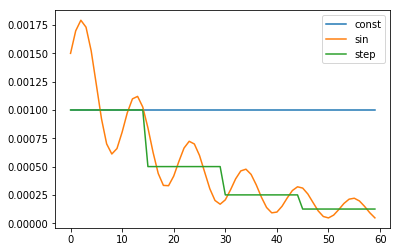

In [22]:
def clean_pytorch_dataloadergen(gen_iter):
    try:
        gen_iter._shutdown_workers()
        for _ in range(100):
            gen_iter.index_queue.put(None)
#         while not gen_iter.data_queue.empty():
#             b = gen_iter.data_queue.get()
        for w in gen_iter.workers:
            w.terminate()
        del gen_iter
    except ex:
        print(ex)


def const_lr(epoch, value=1e-3):
    return value


def step_annealed_lr(epoch, start=1e-3, step_epochs=15, decay_factor=0.5):
    lr_factor = decay_factor ** (epoch // step_epochs)
    return start * lr_factor


def sin_annealed_lr(epoch, freq=0.6, start=1e-3, sin_amp=5e-4, amp_decay_factor=0.97, mean_decay_factor=0.94, min_lr=1e-5):
    base = (numpy.sin(epoch * freq) + 1) * sin_amp * (amp_decay_factor ** epoch)
    mean = start * (mean_decay_factor ** epoch)
    return numpy.clip(base + mean, min_lr, None)


lr_vis_x = numpy.arange(0, 60, 1)
pandas.DataFrame(data=dict(const=const_lr(lr_vis_x),
                           step=step_annealed_lr(lr_vis_x),
                           sin=sin_annealed_lr(lr_vis_x))).plot()

### Run

#### Detect tables

In [23]:
# train_gen = None
# val_gen = None

# EPOCHS_NUM = 30
# BATCH_SIZE = 10
# PART_PER_EPOCH = 0.5
# BATCHES_PER_EPOCH_TRAIN = int(len(train_det_image_ids) * PART_PER_EPOCH // BATCH_SIZE)
# BATCHES_PER_EPOCH_VAL = int(len(val_det_image_ids) * PART_PER_EPOCH // BATCH_SIZE)


# # det_net = StackedUNet1()

# det_net = UNet(out_channels=TOTAL_DET_CLASSES,
#                first_conv_channels=6,
#                depth=4,
#                enc_dilations=[1, 2, 4, 8, 16, 32]).cuda()
# LOSS = dice_bce_loss
# # LOSS = dice_loss
# # LOSS = weighted_dice_loss

# LR_SCHEDULE = step_annealed_lr
# # LR_SCHEDULE = sin_annealed_lr

# det_augmenter = imgaug_pipeline
# # det_augmenter = fake_imgaug_pipeline

# print('total parameters', sum(numpy.product(p.size()) for p in det_net.parameters()))

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         train_gen = iter(DataLoader(SegmDataset(train_det_image_ids,
#                                                 det_augmenter,
#                                                 prepare_det_batch),
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=True,
#                                     num_workers=4))
#         val_gen = iter(DataLoader(SegmDataset(val_det_image_ids,
#                                               det_augmenter,
#                                               prepare_det_batch),
#                                   batch_size=BATCH_SIZE,
#                                   shuffle=True,
#                                   num_workers=2))
#         print('epoch', epoch)

#         lr = LR_SCHEDULE(epoch)
#         print('lr', lr)
#         optimizer = Adam(det_net.parameters(), lr=lr)

#         det_net.train()
#         cur_train_metrics = run_network(det_net, train_gen, BATCHES_PER_EPOCH_TRAIN,
#                                         criterion=LOSS,
#                                         metrics=TRAIN_DET_METRICS,
#                                         optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         det_net.eval()
#         cur_val_metrics = run_network(det_net, val_gen, BATCHES_PER_EPOCH_VAL,
#                                       criterion=LOSS,
#                                       metrics=VAL_DET_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if train_gen:
#             clean_pytorch_dataloadergen(train_gen)
#         if val_gen:
#             clean_pytorch_dataloadergen(val_gen)

#         gc.collect()

#### Segment structure

In [24]:
# train_gen = None
# val_gen = None

# EPOCHS_NUM = 40
# BATCH_SIZE = 16
# PART_PER_EPOCH = 0.5
# BATCHES_PER_EPOCH_TRAIN = int(len(train_int_image_ids) * PART_PER_EPOCH // BATCH_SIZE)
# BATCHES_PER_EPOCH_VAL = int(len(val_int_image_ids) * PART_PER_EPOCH // BATCH_SIZE)


# # net = StackedUNet1().cuda()
# # net = DenseNet1().cuda()

# net = UNet(first_conv_channels=6,
#            depth=4,
#            enc_dilations=[1, 2, 4, 8, 16, 32]).cuda()
# LOSS = dice_bce_loss
# # LOSS = dice_loss
# # LOSS = weighted_dice_loss

# LR_SCHEDULE = step_annealed_lr
# # LR_SCHEDULE = sin_annealed_lr

# int_augmenter = imgaug_pipeline
# # int_augmenter = fake_imgaug_pipeline

# print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         train_gen = iter(DataLoader(SegmDataset(train_int_image_ids,
#                                                 int_augmenter,
#                                                 prepare_int_batch),
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=True,
#                                     num_workers=4))
#         val_gen = iter(DataLoader(SegmDataset(val_int_image_ids,
#                                               int_augmenter,
#                                               prepare_int_batch),
#                                   batch_size=BATCH_SIZE,
#                                   shuffle=True,
#                                   num_workers=2))
#         print('epoch', epoch)

#         lr = LR_SCHEDULE(epoch)
#         print('lr', lr)
#         optimizer = Adam(net.parameters(), lr=lr)

#         net.train()
#         cur_train_metrics = run_network(net, train_gen, BATCHES_PER_EPOCH_TRAIN,
#                                         criterion=LOSS,
#                                         metrics=TRAIN_INT_METRICS,
#                                         optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         net.eval()
#         cur_val_metrics = run_network(net, val_gen, BATCHES_PER_EPOCH_VAL,
#                                       criterion=LOSS,
#                                       metrics=VAL_INT_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if train_gen:
#             clean_pytorch_dataloadergen(train_gen)
#         if val_gen:
#             clean_pytorch_dataloadergen(val_gen)

#         gc.collect()

#### Structured End-to-End

In [25]:
# train_gen = None
# val_gen = None

# EPOCHS_NUM = 30
# BATCH_SIZE = 1
# PART_PER_EPOCH = 0.5
# BATCHES_PER_EPOCH_TRAIN = int(len(train_image_ids) * PART_PER_EPOCH // BATCH_SIZE)
# BATCHES_PER_EPOCH_VAL = int(len(val_image_ids) * PART_PER_EPOCH // BATCH_SIZE)

# net = TableSegmenter().cuda()
# RAW_LOSS = dice_loss
# print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         train_gen = iter(DataLoader(SegmDataset(train_image_ids, imgaug_pipeline, prepare_int_batch),
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=True,
#                                     num_workers=4))
#         val_gen = iter(DataLoader(SegmDataset(val_image_ids, imgaug_pipeline, prepare_int_batch),
#                                   batch_size=BATCH_SIZE,
#                                   shuffle=True,
#                                   num_workers=2))
#         print('epoch', epoch)

#         lr_factor = 0.5 ** (epoch // 20)
#         lr = 1e-3 * lr_factor
#         print('lr', lr)
#         optimizer = Adam(net.parameters(), lr=lr)

#         net.train()
#         cur_train_metrics = run_network_structured(net, train_gen,
#                                                    BATCHES_PER_EPOCH_TRAIN,
#                                                    raw_criterion=RAW_LOSS,
#                                                    metrics=TRAIN_METRICS,
#                                                    optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         net.eval()
#         cur_val_metrics = run_network_structured(net, val_gen,
#                                                  BATCHES_PER_EPOCH_VAL,
#                                                  raw_criterion=RAW_LOSS,
#                                                  metrics=VAL_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if train_gen:
#             clean_pytorch_dataloadergen(train_gen)
#         if val_gen:
#             clean_pytorch_dataloadergen(val_gen)

#         gc.collect()

#### Structured Two-step

In [26]:
# base_segm_model = torch.load('./models/segm_unet1_step_aug').cuda()

In [27]:
# base_train_gen = None
# base_val_gen = None

# EPOCHS_NUM = 60
# BASE_BATCH_SIZE = 4
# BATCH_SIZE = 10
# PART_PER_EPOCH = 0.5
# MEAN_RELS_PER_IMAGE = 2
# BATCHES_PER_EPOCH_TRAIN = int(len(train_int_image_ids) * PART_PER_EPOCH // BASE_BATCH_SIZE) * MEAN_RELS_PER_IMAGE
# BATCHES_PER_EPOCH_VAL = int(len(val_int_image_ids) * PART_PER_EPOCH // BASE_BATCH_SIZE) * MEAN_RELS_PER_IMAGE

# cell_net = ConvFCNClassifier(5, 2,
#                              conv_layers=3,
#                              dilations=[1, 2, 4, 8, 16, 32]).cuda()
# print('receptive field', cell_net.receptive_field)
# CELL_REL_LOSS = F.binary_cross_entropy
# print('total parameters', sum(numpy.product(p.size()) for p in cell_net.parameters()))

# # cell_tamper_channels = [0, 2, 3]
# cell_tamper_channels = []

# # cell_augmenter = imgaug_pipeline
# cell_augmenter = fake_imgaug_pipeline

# CELL_LR_SCHEDULE = step_annealed_lr

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         base_train_gen = iter(DataLoader(SegmDataset(train_int_image_ids,
#                                                      cell_augmenter,
#                                                      prepare_int_batch),
#                                          batch_size=BASE_BATCH_SIZE,
#                                          shuffle=True,
#                                          num_workers=4))
#         train_gen = structured_two_step_datagen(base_train_gen,
#                                                 model=base_segm_model,
#                                                 cuda=True,
#                                                 batch_size=BATCH_SIZE,
#                                                 tamper_channels=cell_tamper_channels)
# #         qq = next(iter(train_gen))[0].data.cpu().numpy()
#         base_val_gen = iter(DataLoader(SegmDataset(val_int_image_ids,
#                                                    cell_augmenter,
#                                                    prepare_int_batch),
#                                        batch_size=BASE_BATCH_SIZE,
#                                        shuffle=True,
#                                        num_workers=2))
#         val_gen = structured_two_step_datagen(base_val_gen,
#                                               model=base_segm_model,
#                                               cuda=True,
#                                               batch_size=BATCH_SIZE,
#                                               tamper_channels=cell_tamper_channels)

#         print('epoch', epoch)

#         lr = CELL_LR_SCHEDULE(epoch)
#         print('lr', lr)
#         optimizer = Adam(cell_net.parameters(), lr=lr)

#         cell_net.train()
#         cur_train_metrics = run_cell_network(cell_net, train_gen, BATCHES_PER_EPOCH_TRAIN,
#                                              criterion=CELL_REL_LOSS,
#                                              metrics=CELL_TRAIN_METRICS,
#                                              optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         cell_net.eval()
#         cur_val_metrics = run_cell_network(cell_net, val_gen, BATCHES_PER_EPOCH_VAL,
#                                            criterion=CELL_REL_LOSS,
#                                            metrics=CELL_VAL_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if base_train_gen:
#             clean_pytorch_dataloadergen(base_train_gen)
#         if base_val_gen:
#             clean_pytorch_dataloadergen(base_val_gen)

#         gc.collect()

### Plot metrics

In [28]:
# train_metrics = pandas.DataFrame(train_metrics)
# val_metrics = pandas.DataFrame(val_metrics)

In [29]:
# pandas.rolling_mean(train_metrics, 100).plot(figsize=(13, 8))

In [30]:
# pandas.rolling_mean(val_metrics[[c for c in val_metrics.columns if 'cell' in c]], 10).plot(figsize=(13, 8))
# pandas.rolling_mean(val_metrics, 100).plot(figsize=(13, 8))

## Predict and visualize

### Table detection

In [31]:
# torch.save(det_net, 'models/det_unet2_aug')

In [32]:
# det_test_net = det_net
det_test_net = torch.load('models/det_unet1_aug').cuda()

In [33]:
# det_test_gen = DataLoader(SegmDataset(val_det_image_ids,
# #                                       imgaug_pipeline,
#                                       fake_imgaug_pipeline,
#                                       prepare_det_batch),
#                           batch_size=4,
#                           shuffle=True,
#                           num_workers=0)

In [34]:
# det_test_metrics = pandas.DataFrame(run_network(det_test_net,
#                                                 det_test_gen,
#                                                 len(val_det_image_ids) // 4,
#                                                 metrics=VAL_DET_METRICS))
# format_metrics_table_md(det_test_metrics)

In [35]:
# det_test_batch = next(iter(det_test_gen))
# det_test_img = det_test_batch[1].cpu().numpy()
# det_test_mask = det_test_batch[2].cpu().numpy()
# det_test_pred = det_test_net(npvar(det_test_batch[1], True))
# det_test_pred_np = det_test_pred.cpu().data.numpy()

In [36]:
# arr_to_img(det_test_img[2][0])

In [37]:
# arr_to_img(mask_to_img(det_test_mask[0]))

In [38]:
# arr_to_img(mask_to_img(det_test_pred_np[2]))

In [39]:
# arr_to_img(mask_to_img(fill_boxes_on_mask_single_image(det_test_pred_np[2])))

#### Results


##### Trained Without Augmentation

###### U-net1+step

|         | bd        | d         | loss      | px_p      | px_r      |
|:--------|:----------|:----------|:----------|:----------|:----------|
| body    | 0.90±0.10 | 0.90±0.10 |           | 0.91±0.12 | 0.92±0.11 |
| caption | 0.76±0.18 | 0.75±0.18 |           | 0.79±0.17 | 0.79±0.21 |
| loss    |           |           | 0.21±0.24 |           |           |

###### DenseNet1


##### Trained With Augmentation

###### U-net1+step

|         | bd        | d         | loss      | px_p      | px_r      |
|:--------|:----------|:----------|:----------|:----------|:----------|
| body    | 0.90±0.10 | 0.89±0.10 |           | 0.93±0.11 | 0.88±0.12 |
| caption | 0.72±0.20 | 0.66±0.20 |           | 0.81±0.19 | 0.62±0.24 |
| loss    |           |           | 0.25±0.24 |           |           |

###### DenseNet1


#### Old Results

##### torch4_net
	d body	d caption	loss
    mean	0.889029	0.724086	0.238287
    std	0.104200	0.185334	0.262712

### Table structure segmentation

In [40]:
# torch.save(net, 'models/segm_unet1_step_aug')

In [41]:
# test_net = net

In [42]:
# test_net = torch.load('models/segm_unet1_step_aug').cuda()

In [43]:
# test_gen = DataLoader(SegmDataset(val_int_image_ids,
#                                   imgaug_pipeline,
# #                                   fake_imgaug_pipeline,
#                                   prepare_int_batch),
#                       batch_size=4,
#                       shuffle=True,
#                       num_workers=0)

In [44]:
# test_metrics = pandas.DataFrame(run_network(test_net,
#                                             test_gen,
#                                             100,
#                                             metrics=TEST_INT_METRICS))
# format_metrics_table_md(test_metrics)

In [45]:
# test_batch = next(iter(test_gen))
# test_pred = test_net(npvar(test_batch[1], True))
# test_pred_np = test_pred.cpu().data.numpy()

In [46]:
# arr_to_img(test_batch[1][1][0].cpu().numpy())

In [47]:
# arr_to_img(mask_to_img(test_batch[2][1].cpu().numpy()))

In [48]:
# arr_to_img(mask_to_img(test_pred_np[1]))

#### Results


##### Trained Without Augmentation

###### U-net1+step

*Eval With Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.86±0.05 |           |
| cell               | 0.43±0.20 | 0.60±0.25 | 0.38±0.19 | 0.47±0.19 |           |
| loss               |           |           |           |           | 1.33±0.45 |
| same_col_other_row | 0.01±0.03 | 0.06±0.10 | 0.01±0.02 | 0.37±0.18 |           |
| same_row_other_col | 0.01±0.02 | 0.03±0.09 | 0.00±0.02 | 0.50±0.17 |           |

*Eval Without Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 1.00±0.00 |           |
| cell               | 0.97±0.02 | 1.00±0.01 | 0.95±0.03 | 0.96±0.00 |           |
| loss               |           |           |           |           | 0.11±0.02 |
| same_col_other_row | 0.01±0.02 | 0.02±0.07 | 0.00±0.01 | 0.87±0.02 |           |
| same_row_other_col | 0.02±0.04 | 0.10±0.16 | 0.01±0.02 | 0.91±0.01 |           |

###### U-net1+sin

*Eval With Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.86±0.07 |           |
| cell               | 0.28±0.21 | 0.35±0.25 | 0.25±0.20 | 0.29±0.21 |           |
| loss               |           |           |           |           | 2.13±0.60 |
| same_col_other_row | 0.00±0.01 | 0.02±0.06 | 0.00±0.01 | 0.27±0.19 |           |
| same_row_other_col | 0.01±0.01 | 0.04±0.09 | 0.00±0.01 | 0.33±0.19 |           |

*Eval Without Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 1.00±0.00 |           |
| cell               | 0.97±0.02 | 1.00±0.00 | 0.95±0.03 | 0.96±0.00 |           |
| loss               |           |           |           |           | 0.12±0.02 |
| same_col_other_row | 0.01±0.02 | 0.02±0.08 | 0.00±0.01 | 0.87±0.02 |           |
| same_row_other_col | 0.02±0.04 | 0.10±0.17 | 0.01±0.02 | 0.90±0.02 |           |

###### DenseNet1+step

*Eval With Augmentation*

*Eval Without Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.98±0.01 |           |
| cell               | 0.97±0.02 | 1.00±0.01 | 0.95±0.03 | 0.93±0.01 |           |
| loss               |           |           |           |           | 0.32±0.02 |
| same_col_other_row | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.27±0.01 |           |
| same_row_other_col | 0.13±0.08 | 0.50±0.23 | 0.08±0.05 | 0.64±0.02 |           |

###### DenseNet1+sin

*Eval With Augmentation*

*Eval Without Augmentation*


##### Trained With Augmentation

###### U-net1+step

*Eval With Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.99±0.00 |           |
| cell               | 0.93±0.03 | 0.99±0.01 | 0.89±0.05 | 0.92±0.01 |           |
| loss               |           |           |           |           | 0.16±0.03 |
| same_col_other_row | 0.01±0.02 | 0.03±0.08 | 0.00±0.01 | 0.82±0.02 |           |
| same_row_other_col | 0.04±0.04 | 0.16±0.17 | 0.02±0.03 | 0.86±0.03 |           |

*Eval Without Augmentation*

|                    | bf        | bp        | br        | d         | loss      |
|:-------------------|:----------|:----------|:----------|:----------|:----------|
| body               | 0.00±0.00 | 0.00±0.00 | 0.00±0.00 | 0.99±0.00 |           |
| cell               | 0.96±0.02 | 0.98±0.01 | 0.94±0.03 | 0.91±0.01 |           |
| loss               |           |           |           |           | 0.21±0.03 |
| same_col_other_row | 0.01±0.02 | 0.03±0.09 | 0.00±0.01 | 0.83±0.02 |           |
| same_row_other_col | 0.05±0.05 | 0.20±0.18 | 0.03±0.03 | 0.85±0.02 |           |

###### U-net1+sin

*Eval With Augmentation*

*Eval Without Augmentation*

###### DenseNet1+step

*Eval With Augmentation*

*Eval Without Augmentation*

###### DenseNet1+sin

*Eval With Augmentation*

*Eval Without Augmentation*

### Intracell classification (second step)

In [49]:
# torch.save(cell_net, './models/cell_fcn1_no_aug')

In [50]:
cell_test_net = torch.load('models/cell_fcn1_no_aug').cuda()
cell_test_base_segm_model = torch.load('models/segm_unet1_step_aug').cuda()

In [51]:
# cell_test_gen = structured_two_step_datagen(DataLoader(SegmDataset(val_int_image_ids,
#                                                                    imgaug_pipeline,
# #                                                                    fake_imgaug_pipeline,
#                                                                    prepare_int_batch),
#                                                        batch_size=4,
#                                                        shuffle=True,
#                                                        num_workers=0),
#                                             model=cell_test_base_segm_model,
#                                             cuda=True,
#                                             batch_size=10, 
#                                             tamper_channels=[])

In [52]:
# cell_test_metrics = pandas.DataFrame(run_cell_network(cell_test_net,
#                                                       cell_test_gen,
#                                                       1000,
#                                                       metrics=CELL_TRAIN_METRICS))
# format_metrics_table_md(cell_test_metrics)

In [53]:
# cell_test_batch = next(iter(cell_test_gen))

# cell_test_pred = cell_test_net(cell_test_batch[0])
# cell_test_pred_np = cell_test_pred.cpu().data.numpy()

# cell_test_in_np = cell_test_batch[0].data.cpu().numpy()
# cell_test_gold_np = cell_test_batch[1].data.cpu().numpy()

In [54]:
# cell_test_cls = 0
# cell_err_idx = numpy.where((cell_test_pred_np[:, cell_test_cls] > 0.5) ^ (cell_test_gold_np[:, cell_test_cls] > 0.5))[0]
# cell_err_idx

In [55]:
# arr_to_img(mask_to_img(cell_test_in_np[9]))

#### Results

##### Trained Without Augmentation



###### cell_fcn1_no_aug + segm_unet1_step_aug dirty

*eval no aug*

|          | f1        | loss      | p         | r         |
|:---------|:----------|:----------|:----------|:----------|
| loss     |           | 0.12±0.17 |           |           |
| same_col | 0.98±0.07 |           | 0.97±0.10 | 0.99±0.03 |
| same_row | 0.98±0.05 |           | 1.00±0.02 | 0.97±0.08 |


*eval with aug*

|          | f1        | loss      | p         | r         |
|:---------|:----------|:----------|:----------|:----------|
| loss     |           | 0.12±0.19 |           |           |
| same_col | 0.97±0.07 |           | 0.96±0.10 | 0.99±0.03 |
| same_row | 0.98±0.05 |           | 0.99±0.03 | 0.97±0.08 |

###### cell_fcn1_no_aug + segm_unet1_step_aug clean

*eval no aug*

|          | f1        | loss      | p         | r         |
|:---------|:----------|:----------|:----------|:----------|
| loss     |           | 0.06±0.09 |           |           |
| same_col | 0.99±0.04 |           | 0.99±0.06 | 1.00±0.02 |
| same_row | 0.99±0.03 |           | 1.00±0.02 | 0.99±0.04 |


*eval with aug*

|          | f1        | loss      | p         | r         |
|:---------|:----------|:----------|:----------|:----------|
| loss     |           | 0.08±0.16 |           |           |
| same_col | 0.99±0.05 |           | 0.98±0.06 | 1.00±0.02 |
| same_row | 0.98±0.04 |           | 0.98±0.06 | 0.99±0.05 |


##### Trained With Augmentation

## Parse tables using all built models

In [56]:
def reorder_cells(c1, c2, cells, dim):
    b1, b2 = cells[c1], cells[c2]
    coord1, coord2 = b1[dim], b2[dim]
    coord1o, coord2o = b1[dim+2], b2[dim+2]
    if coord1 < coord2:
        return c1, c2, coord2 > coord1o
    else:
        return c2, c1, coord1 > coord2o


class SeqIdGen(object):
    def __init__(self):
        self.next_id = 0

    def __call__(self):
        res = self.next_id
        self.next_id += 1
        return res


def make_equivalence_classes(neighborhood):
    cell2cls = {}
    gen_cls_id = SeqIdGen()

    refs_by_cell = { c : 0
                    for cur_cell, neighs in neighborhood.items()
                    for lst in ((cur_cell,), neighs)
                    for c in lst }
    for cur_cell, neighs in neighborhood.items():
        for oc in neighs:
            refs_by_cell[oc] += 1
    cells_with_no_refs = [c
                          for c, refs_n in refs_by_cell.items()
                          if refs_n == 0]

    for cls_seed in cells_with_no_refs:
        cur_queue = collections.deque([(cls_seed, { gen_cls_id() })])

        while len(cur_queue) > 0:
            cur_cell, cur_cls = cur_queue.popleft()
            cell2cls[cur_cell] = cur_cls

            cur_neighbors = neighborhood.get(cur_cell, [])
            many_neighbors = len(cur_neighbors) > 1
            for oc in cur_neighbors:
                oc_cls = set(cur_cls)
                if many_neighbors:
                    oc_cls.add(gen_cls_id())
                cur_queue.append((oc, oc_cls))

    return cell2cls


def reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes, prob_threshold=0.5):
    row_neighbors = collections.defaultdict(set)
    col_neighbors = collections.defaultdict(set)

    for (c1, c2), probs in intracell_space_classes.items():
        b1 = cells[c1]
        b2 = cells[c2]
        if probs[STRUCT_SAME_ROWS_I] > prob_threshold:
            rc1, rc2, do_not_overlap = reorder_cells(c1, c2, cells, 1) # ensure rc1 is in the left of rc2
            if do_not_overlap:
                row_neighbors[rc1].add(rc2)
        if probs[STRUCT_SAME_COLS_I] > prob_threshold:
            cc1, cc2, do_not_overlap = reorder_cells(c1, c2, cells, 0) # ensure cc1 is above of cc2
            if do_not_overlap:
                col_neighbors[cc1].add(cc2)

    cell2rows = make_equivalence_classes(row_neighbors)
    cell2cols = make_equivalence_classes(col_neighbors)

    rows = collections.defaultdict(set)
    for cell_i, cell_rows_idx in cell2rows.items():
        for row_i in cell_rows_idx:
            rows[row_i].add(cell_i)

    cols = collections.defaultdict(set)
    for cell_i, cell_cols_idx in cell2cols.items():
        for col_i in cell_cols_idx:
            cols[col_i].add(cell_i)

    row_boxes = [just_box_union([cells[i] for i in row_idx])
                 for row_idx in rows.values()]
    row_boxes.sort(key=lambda b: b[0])

    col_boxes = [just_box_union([cells[i] for i in col_idx])
                 for col_idx in cols.values()]
    col_boxes.sort(key=lambda b: b[1])
    return (body,
            cells,
            row_boxes,
            col_boxes)


def get_segm_mask_batch(images, segm_model, cuda=True):
    batch_segm_input = npvar(numpy.expand_dims(numpy.array([numpy.array(img).astype('float32')
                                                            for img in images]),
                                               1) / 255.0,
                             cuda)
    return segm_model(batch_segm_input).data.cpu().numpy()


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# подключить det_model
# копировать выделенные фрагменты в отдельные картинки и их сегментировать с помощью segm_model


def ceil_mod(x, mod):
    if x % mod == 0:
        return x
    return ((x // mod) + 1) * mod


def choose_image_size_multiple_of(min_size, multiplier=32):
    return (ceil_mod(min_size[0], multiplier),
            ceil_mod(min_size[1], multiplier))


def fit_image_size(src_image, multiplier=128, mode='L', filler=255):
    new_size = choose_image_size_multiple_of(src_image.size,
                                             multiplier=multiplier)
    result = Image.new(mode,
                       new_size,
                       filler)
    result.paste(src_image)
    return result


def box_to_abs_coords(box, parent):
    py1, px1, py2, px2 = parent
    by1, bx1, by2, bx2 = box
    return (by1+py1, bx1+px1, by2+py1, bx2+px1)


def box_lst_to_abs_coords(boxes, parent):
    return [box_to_abs_coords(box, parent) for box in boxes]


def parse_tables_from_images(images, det_model, segm_model, cell_model, cuda=True, cell_batch_size=64, min_body_area=300, body_padding=0):
    tables_by_image = []
    grids_by_image = []

    batch_det_output = get_segm_mask_batch(images, det_model, cuda)
    for src_image, det_mask in zip(images, batch_det_output):
        cur_img_tables = []
        cur_img_grids = []

#         display(arr_to_img(mask_to_img(det_mask)))
        det_boxes_by_channel = get_boxes_by_channel(det_mask)
    
        
        cur_image_captions = det_boxes_by_channel[DET_CAPTION_CHANNEL_I]
        cur_image_bodies = det_boxes_by_channel[DET_BODY_CHANNEL_I]
        cur_image_bodies.sort(key=box_area, reverse=True)
        for body in cur_image_bodies:
            if box_area(body) < min_body_area:
                continue
            ext_body = (max(0, body[0]-body_padding),
                        max(0, body[1]-body_padding),
                        min(src_image.size[1], body[2]+body_padding),
                        min(src_image.size[0], body[3]+body_padding))
            cropped_image = src_image.crop((ext_body[1], ext_body[0], ext_body[3], ext_body[2]))
            src_image_for_segm = fit_image_size(cropped_image)
            segm_output = get_segm_mask_batch([src_image_for_segm], segm_model, cuda)[0]

#             display(arr_to_img(mask_to_img(segm_output)))

            # here should go a loop over all found bodies
            _, cells, grid, cell_idx, intracell_relations = table_grid_from_intracell_mask(segm_output,
                                                                                           input_image=(numpy.array(src_image_for_segm).astype('float32') / 255.0))
            output_cell_coords = box_lst_to_abs_coords(cells, ext_body)
            intracell_relation_keys = list(intracell_relations.keys())
            intracell_relation_classes = {}
            for batch_start in range(0, len(intracell_relation_keys), cell_batch_size):
                batch_rel_keys = intracell_relation_keys[batch_start:batch_start+cell_batch_size]
                batch_relations = [(cells[i1], cells[i2], intracell_relations[(i1, i2)])
                                   for (i1, i2) in batch_rel_keys]

                cell_img_inp = npvar(segm_output, cuda).unsqueeze(0)
                cell_batch_input = CellRelConvFCNClassifier.make_batch(cell_img_inp,
                                                                       [batch_relations])
                cell_batch_output = cell_model(cell_batch_input).data.cpu().numpy()
                for rel_key, cur_cell_pair_out in zip(batch_rel_keys, cell_batch_output):
                    intracell_relation_classes[rel_key] = cur_cell_pair_out
            cur_img_grids.append((body, output_cell_coords, grid, cell_idx, intracell_relation_classes))
            cur_img_tables.append(reconstruct_table_from_grid(body, output_cell_coords, grid, cell_idx, intracell_relation_classes))

        tables_by_image.append(cur_img_tables)
        grids_by_image.append(cur_img_grids)

    return tables_by_image, grids_by_image


def make_boxes_with_channels_from_parsed_table(table_info):
    body, cells, rows, cols = table_info
    boxes = [(1, body)]
    boxes.extend((2, b) for b in cells)
    boxes.extend((3, b) for b in rows)
    boxes.extend((4, b) for b in cols)
    return boxes


def make_demo_mask_from_parsed_table(img, table_info):
    boxes = make_boxes_with_channels_from_parsed_table(table_info)
    return make_demo_mask(img, boxes)


def make_intracell_rels_symmetric(intracell_relation_classes):
    src_keys = list(intracell_relation_classes.keys())
    sums = collections.defaultdict(lambda: numpy.zeros(2, dtype='float32'))
    norms = collections.defaultdict(float)
    for (c1, c2), probs in intracell_relation_classes.items():
        if c1 > c2:
            c1, c2 = c2, c1
        symmetric_key = (c1, c2)
        sums[symmetric_key] += probs
        norms[symmetric_key] += 1
    result = {}
    for key in src_keys:
        c1, c2 = key
        if c1 > c2:
            c1, c2 = c2, c1
        symmetric_key = (c1, c2)
        result[key] = sums[symmetric_key] / norms[symmetric_key]
    return result


def make_demo_mask_from_grid_info(img, grid_info, min_prob=0.5, cells_of_interest=None, print_probs=False):
    body, cells, grid, cell_idx, intracell_relation_classes = grid_info
    rel_mask = numpy.zeros((3, img.size[1], img.size[0]), dtype='uint8')
    for (c1, c2), probs in intracell_relation_classes.items():
        if not cells_of_interest is None:
            if not (c1 in cells_of_interest or c2 in cells_of_interest):
                continue
        b1 = cells[c1]
        b2 = cells[c2]
        for ch_i in range(probs.shape[0]):
            if probs[ch_i] < min_prob:
                continue
            if print_probs:
                print(c1, c2, ch_i, probs[ch_i])
            draw_intercell_mask(rel_mask[ch_i],
                                b1,
                                b2,
                                'same_row',
                                value=int(probs[ch_i]*255))
    rel_mask = mask_to_img(rel_mask.astype('float32') / 255.0)

    rel_mask_img = arr_to_img(rel_mask)
    cells_for_display = cells if cells_of_interest is None else [cells[i] for i in cells_of_interest]
    base_mask = make_demo_mask(img, [(1, body)] + [(2, c)
                                                   for c in cells_for_display])
    return Image.blend(rel_mask_img.convert('RGB'), base_mask, 0.5)


def get_either(m, k):
    r = m.get(k, None)
    if r is None:
        r = m.get((k[1], k[0]), None)
    return r

In [34]:
test_img_id = val_det_image_ids[10]
# test_img_filename = test_img_id + IN_IMG_SUFFIX
# test_img_filename = './data/dc/docs_pages_flat/2012-3.pdf_0001.png'
# test_img_filename = './data/dc/docs_pages_flat/2003-16.pdf_0004.png'
# test_img_filename = './data/dc/docs_pages_flat/2002-5-mucin-gene-muc1-transfected-dendritic-cells-as-vaccine-results-of-a-phase-i-ii-clinical-trial.pdf_0001.png'
test_img_filename = './data/dc/docs_pages_flat/2010-1.pdf_0002.png'
test_image = fit_image_size(load_image_opaque(test_img_filename, mode='L'))
# test_image

In [ ]:
tables_by_image, grids_by_image = parse_tables_from_images([test_image],
                                                           det_test_net,
                                                           cell_test_base_segm_model,
                                                           cell_test_net,
                                                           cuda=True,
                                                           cell_batch_size=64)

In [ ]:
test_grid_ic_rels = grids_by_image[0][0][-1]
print('test_grid_ic_rels', len(test_grid_ic_rels), numpy.array(list(test_grid_ic_rels.values())).mean(0))
test_grid_ic_rels_sym = make_intracell_rels_symmetric(test_grid_ic_rels)
print('test_grid_ic_rels_sym', len(test_grid_ic_rels_sym), numpy.array(list(test_grid_ic_rels_sym.values())).mean(0))

In [ ]:
# print(get_either(test_grid_ic_rels, (5, 14)))
make_demo_mask_from_grid_info(test_image, grids_by_image[0][0], min_prob=0.7)

In [ ]:
# test_image_segm_mask = get_segm_mask_batch([test_image], cell_test_base_segm_model)
# arr_to_img(mask_to_img(test_image_segm_mask[0]))

In [ ]:
# make_demo_mask_from_parsed_table(test_image, tables_by_image[0][0])

### Process PDF files

In [76]:
def image_box_to_pdf_coords(box, cropbox):
    return convert_coords_to_pq(numpy.array(box) * PIXELS_TO_POINTS_FACTOR, cropbox)

def process_pdf(in_file, det_model, segm_model, cell_model, tmp_dir_prefix='/tmp', pages=None, cuda=True, cell_batch_size=64, min_cols=2, min_rows=2, min_cells_with_text=0.5):
    result = []
    pdf = PdfMinerWrapper(in_file)
    pdf.load()
    pdf_basename = os.path.splitext(os.path.basename(in_file))[0]
    with tempfile.TemporaryDirectory(dir=tmp_dir_prefix) as wd:
        page_filenames = pdf_to_pages(in_file, wd, pages=pages)

        for page_fname in page_filenames:
            page_i = int(os.path.splitext(os.path.basename(page_fname))[0])
            cropbox = pdf.get_page(page_i)[1].cropbox

            page_image = fit_image_size(load_image_opaque(page_fname, mode='L'))
            tables_by_image, grids_by_image = parse_tables_from_images([page_image],
                                                                       det_model,
                                                                       segm_model,
                                                                       cell_model,
                                                                       cuda=cuda,
                                                                       cell_batch_size=cell_batch_size)
            page_result = []
            for body, cells, rows, cols in tables_by_image[0]:
                if len(rows) < min_rows or len(cols) < min_cols:
                    continue
                cell_texts = [pdf.get_text(page_i, [image_box_to_pdf_coords(cell, cropbox)])
                              for cell in cells]
                cells_with_text = sum(1 for ct in cell_texts if len(ct.strip()) > 0)
                if cells_with_text / float(len(cells)) < min_cells_with_text:
                    continue
                page_result.append((image_box_to_pdf_coords(body, cropbox),
                                    [image_box_to_pdf_coords(cell, cropbox) for cell in cells],
                                    [image_box_to_pdf_coords(row, cropbox) for row in rows],
                                    [image_box_to_pdf_coords(col, cropbox) for col in cols],
                                    cell_texts))
#                 page_result.append((body,
#                                     cells,
#                                     rows,
#                                     cols,
#                                     cell_texts))
#                 print(cells[0])
#                 display(make_demo_mask_from_parsed_table(page_image, (body, cells, rows, cols)))
            result.append((page_i, page_result))
    return result

In [79]:
test_pdf_tables = process_pdf('./data/dc/src_docs/2010-1.pdf',
                              det_test_net,
                              cell_test_base_segm_model,
                              cell_test_net,
                              pages=[2])

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### Export markup to ICDAR 2013 Table Competition format

In [92]:
ICDAR_GOOD_TXT_RE = re.compile(r'\w+')
def clean_text_for_icdar(t):
    return ''.join(ICDAR_GOOD_TXT_RE.findall(t)).upper()


def make_icdar_bb(root, bb):
    left, bottom, right, top = bb
    root.append(lxml.etree.Element('bounding-box',
                                   x1=str(int(math.floor(left))),
                                   y1=str(int(math.floor(bottom))),
                                   x2=str(int(math.ceil(right))),
                                   y2=str(int(math.ceil(top)))))


def table2icdar(parent, page_no, table, table_id, for_region=True):
    body, cells, rows, cols, cell_texts = table

    table_root = lxml.etree.Element('table',
                                    id=str(table_id))
    parent.append(table_root)

    region = lxml.etree.Element('region',
                                **{'id': '1',
                                   'page': str(page_no+1),
#                                    'col-increment': '0',
#                                    'row-increment': '0'
                                  })
    table_root.append(region)

    if for_region:
        make_icdar_bb(region, body)
    else:
#         print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        cell2rows = group_by_intersection(rows, cells)
        cell2cols = group_by_intersection(cols, cells)
#         print('structure')
#         print(len(cells))
#         print(cell2rows)
#         print(cell2cols)
        for i, (cell, txt) in enumerate(zip(cells, cell_texts)):
            if len(cell2cols[i]) == 0 or len(cell2rows[i]) == 0:
#                 print('unlinked cell!!')
                continue
            cell_node = lxml.etree.Element('cell',
                                           **{'id': str(i),
                                              'start-col': str(min(cell2cols[i])),
                                              'start-row' : str(min(cell2rows[i]))})
            make_icdar_bb(cell_node, cell)
            content = lxml.etree.Element('content')
            content.text = clean_text_for_icdar(txt)
            cell_node.append(content)
            region.append(cell_node)


def pdf_tables2icdar(outfile, tables, for_region=True):
    root = lxml.etree.Element('document',
                              filename=os.path.basename(outfile))
    table_id = 0
    for page_no, page_tables in tables:
        for table in page_tables:
            table2icdar(root, page_no, table, table_id, for_region=for_region)
            table_id += 1
    with open(outfile, 'w') as f:
        f.write(lxml.etree.tostring(root, pretty_print=True).decode('utf8'))


def process_pdf_icdar(infile, outdir, det_model, segm_model, cell_model):
    doc_tables = process_pdf(infile, det_model, segm_model, cell_model)
    basename = os.path.splitext(os.path.basename(infile))[0]
    pdf_tables2icdar(os.path.join(outdir, basename + '-reg-result.xml'),
                     doc_tables,
                     for_region=True)
    pdf_tables2icdar(os.path.join(outdir, basename + '-str-result.xml'),
                     doc_tables,
                     for_region=False)


def process_pdf_files_icdar(infiles, outdir, det_model, segm_model, cell_model):
    for file in tqdm.tqdm(list(infiles)):
        process_pdf_icdar(file, outdir, det_model, segm_model, cell_model)

In [93]:
process_pdf_icdar('./data/icdar2013-competition-dataset-with-gt/competition-dataset-us/us-001.pdf',
                  './data/icdar2013-pred/',
                  det_test_net,
                  cell_test_base_segm_model,
                  cell_test_net)

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [82]:
process_pdf_files_icdar(glob.glob('./data/icdar2013-competition-dataset-with-gt/*/*.pdf'),
                        './data/icdar2013-pred/',
                        det_test_net,
                        cell_test_base_segm_model,
                        cell_test_net)

  0%|          | 0/67 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [89]:
class XmlValidator(object):
    def __init__(self, dtd_file):
        with open(dtd_file, 'r') as f:
            tree = lxml.etree.parse(f)
            self.schema = lxml.etree.XMLSchema(tree)

    def __call__(self, xml_file):
        with open(xml_file, 'r') as f:
            tree = lxml.etree.parse(f)
        is_valid = self.schema.validate(tree)
        if is_valid:
            errors = []
        else:
            errors = self.schema.error_log
        return is_valid, errors

reg_dtd = XmlValidator('./data/competition-entry-region-model.xsd')
str_dtd = XmlValidator('./data/competition-entry-structure-model.xsd')

In [90]:
reg_dtd('./data/icdar2013-pred/us-001-reg-result.xml')

(True, [])

In [91]:
str_dtd('./data/icdar2013-pred/us-001-str-result.xml')

(False,
 /notebook/data/icdar2013-pred/us-001-str-result.xml:4:0:ERROR:SCHEMASV:SCHEMAV_CVC_COMPLEX_TYPE_4: Element 'cell': The attribute 'id' is required but missing.
 /notebook/data/icdar2013-pred/us-001-str-result.xml:8:0:ERROR:SCHEMASV:SCHEMAV_CVC_COMPLEX_TYPE_4: Element 'cell': The attribute 'id' is required but missing.
 /notebook/data/icdar2013-pred/us-001-str-result.xml:12:0:ERROR:SCHEMASV:SCHEMAV_CVC_COMPLEX_TYPE_4: Element 'cell': The attribute 'id' is required but missing.
 /notebook/data/icdar2013-pred/us-001-str-result.xml:16:0:ERROR:SCHEMASV:SCHEMAV_CVC_COMPLEX_TYPE_4: Element 'cell': The attribute 'id' is required but missing.
 /notebook/data/icdar2013-pred/us-001-str-result.xml:20:0:ERROR:SCHEMASV:SCHEMAV_CVC_COMPLEX_TYPE_4: Element 'cell': The attribute 'id' is required but missing.
 /notebook/data/icdar2013-pred/us-001-str-result.xml:24:0:ERROR:SCHEMASV:SCHEMAV_CVC_COMPLEX_TYPE_4: Element 'cell': The attribute 'id' is required but missing.
 /notebook/data/icdar2013-pr

### Process images from a folder

In [ ]:
import svgwrite

In [ ]:
def color_tuple_to_html(c):
    return '#' + '{:02x}{:02x}{:02x}'.format(*c)


def extracted_tables_to_svg(page_img, tables, out_file):
    img_buf = io.StringIO()
    page_img.save(img_buf, format="png")
    img_str = base64.b64encode(img_buf.getvalue()).decode('ascii')
    img_data_url = 'data:image/png;base64,' + img_str

    dwg = svgwrite.Drawing(out_file,
                           size=page_img.size,
                           profile='tiny')
    dwg.add(dwg.image(img_data_url))

    for table_info in tables:
        for cls, (y1, x1, y2, x2) in make_boxes_with_channels_from_parsed_table(table_info):
            dwg.add(dwg.rect((x1, y1),
                             (x2 - x1, y2 - y1),
                             **{'fill' : 'none',
                                'stroke' : color_tuple_to_html(CLS_TO_COLOR[cls]),
                                'stroke-opacity' : 1}))

    dwg.save()

In [61]:
play_files = list(glob.glob('./data/dc/docs_pages_flat/*.png'))

In [62]:
play_files[:10]

['./data/dc/docs_pages_flat/2012-3.pdf_0001.png',
 './data/dc/docs_pages_flat/2003-16.pdf_0004.png',
 './data/dc/docs_pages_flat/2002-5-mucin-gene-muc1-transfected-dendritic-cells-as-vaccine-results-of-a-phase-i-ii-clinical-trial.pdf_0001.png',
 './data/dc/docs_pages_flat/2010-1.pdf_0002.png',
 './data/dc/docs_pages_flat/2003-9.pdf_0006.png',
 './data/dc/docs_pages_flat/2001-10-dendritic-cell-based-xenoantigen-vaccination-for-prostate-cancer-immunotherapy.pdf_0005.png',
 './data/dc/docs_pages_flat/2011-5.pdf_0001.png',
 './data/dc/docs_pages_flat/2003-6.pdf_0003.png',
 './data/dc/docs_pages_flat/2002-2-dendritic-cell-immunotherapy-for-patients-with-metastatic-renal-cell-carcinoma-university-of-tokyo-experience.pdf_0004.png',
 './data/dc/docs_pages_flat/2003-16.pdf_0005.png']